In [41]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]) 
])


In [43]:
dataset = datasets.ImageFolder(root='C:/Users/HP/Desktop/dl_project/Celebrity_Recognition/dataset/cropped/', transform=transform)


In [44]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [45]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
print(dataset.classes)        
print(dataset.class_to_idx)  


['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
{'Angelina Jolie': 0, 'Brad Pitt': 1, 'Denzel Washington': 2, 'Hugh Jackman': 3, 'Jennifer Lawrence': 4, 'Johnny Depp': 5, 'Kate Winslet': 6, 'Leonardo DiCaprio': 7, 'Megan Fox': 8, 'Natalie Portman': 9, 'Nicole Kidman': 10, 'Robert Downey Jr': 11, 'Sandra Bullock': 12, 'Scarlett Johansson': 13, 'Tom Cruise': 14, 'Tom Hanks': 15, 'Will Smith': 16}


In [47]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Mean and std used for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to unnormalize and show an image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) 
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')


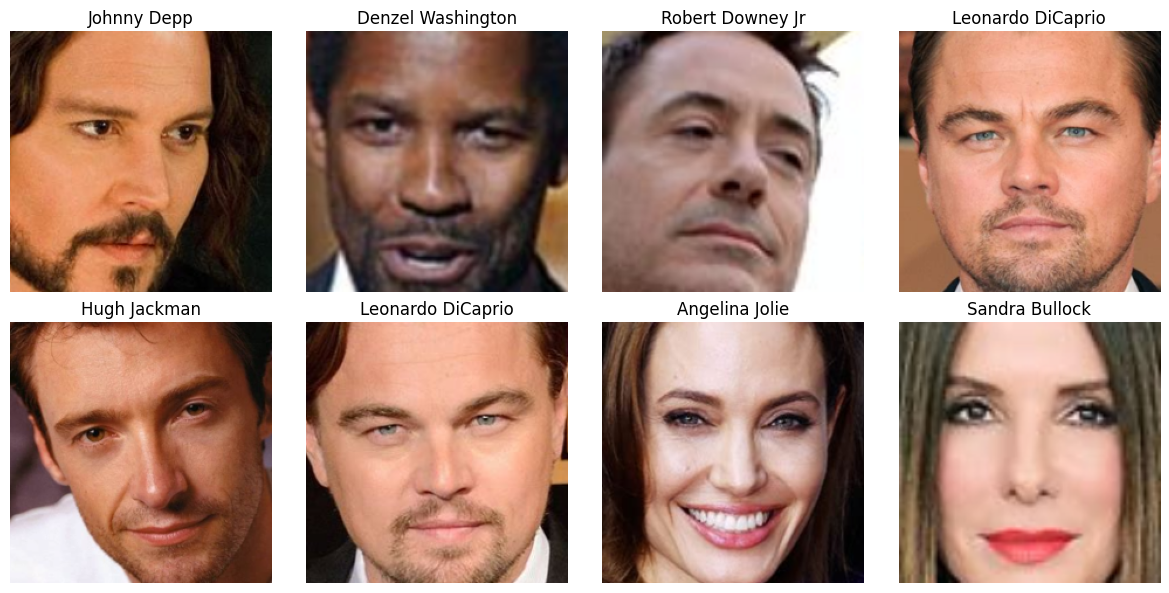

In [ ]:
# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)


plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=dataset.classes[labels[i]])
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Training loop
num_epochs = 20 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")


    early_stopping(val_acc, model)
    if early_stopping.early_stop:
        print("⏹️ Early stopping triggered. Stopping training.")
        break


model.load_state_dict(early_stopping.best_model_wts)


Epoch [1/20] - Loss: 1.0596 - Train Acc: 0.6745 - Val Acc: 0.5036
Epoch [2/20] - Loss: 0.2229 - Train Acc: 0.9355 - Val Acc: 0.9167
Epoch [3/20] - Loss: 0.1432 - Train Acc: 0.9527 - Val Acc: 0.7609
Epoch [4/20] - Loss: 0.2032 - Train Acc: 0.9336 - Val Acc: 0.7319
⏹️ Early stopping triggered. Stopping training.


<All keys matched successfully>

In [52]:
model.load_state_dict(early_stopping.best_model_wts)

torch.save(model.state_dict(), "best_model.pkl")
print("Best model saved as 'best_model.pkl'")

Best model saved as 'best_model.pkl'
